# **The Stokes equations - adaptive mesh refinement**
**Cecilia Rydefalk**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Stokes equations using adaptive mesh refinement, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [0]:
"""This program is a lab report in the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# This file is an assignment in the course DD2365 Advanced Computation in Fluid Mechanics
# This report is based on a template provided by Johan Hoffman
# KTH Royal Institute of Technology, Stockholm, Sweden

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot

import numpy as np
from matplotlib import pyplot as plt

# **Introduction**

The Stokes equations take the form

$\nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with boundary conditions for $\partial \Omega = \Gamma_D \cup \Gamma_N \cup \Gamma_F$

$
u=g_D,\quad x\in \Gamma_D
$

$
u=0,\quad x\in \Gamma_F
$

$
-\nabla u\cdot n + pn = 0,\quad x\in \Gamma_N
$

Here $\Gamma_D$ is the part of the boundary where we prescribe Dirichlet boundary conditions, $\Gamma_N$ a part of the boundary where we apply a homogeneous Neumann boundary condition, and $\Gamma_F$ the part of the boundary over which we want to compute the force. 

The weak (variational) form of the equations is: find a solution $(u,p)\in V\times Q$ such that 

$- (p,\nabla \cdot v) + (\nabla u,\nabla v) + (\nabla \cdot u, q) = (f,v)$

for all test functions $(v,q) \in \hat V \times Q$, where $\hat V$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$.

Here we present a FEniCS implementation of a mixed finite element method to solve the Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

**Approach**

We seek a finite element approximation $(U,P)\in V_h\times Q_h$ such that 

$- (P,\nabla \cdot v) + (\nabla U,\nabla v) + (\nabla \cdot U, q) = (f,v)$

for all test functions $(v,q) \in \hat V_h \times Q_h$, where $\hat V_h$ are the test functions $v$ such that $v=0$ for $x\in \Gamma_D$. Here $V_h\subset V, Q_h\subset Q, \hat V_h\subset \hat V$ are finite dimensional subspaces defined over the computational mesh by finite element basis functions. 

To implement the velocity Dirichlet boundary conditions we use a penalty formulation, with a penalty parameter $\gamma = C/h$, where $C>0$ is a constant and $h$ is the local mesh size. At the outflow a "do nothing" zero stress boundary condition is used, meaning that the boundary condition is enforced weakly by setting the boundary integral to zero. 

We consider the linear functional $F:V\times Q\rightarrow {\mathbb R}$, 

$F(v,q) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} + \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}$

corresponding to weighted mean values of $v$ and $q$, and the force on the surface $\Gamma_F\subset \partial \Omega$, 
which generates the adjoint Stokes equations

$-\nabla \theta -\Delta \varphi = \psi_1$

$\quad -\nabla \cdot \varphi=\psi_2,$

together with boundary conditions that reflect the primal equations and the chosen functional. 

$
\varphi=0,\quad x\in \Gamma_D
$

$
\varphi=\psi_3,\quad x\in \Gamma_F
$

$
- \nabla \varphi \cdot n - \theta n=0, \quad x\in \Gamma_N
$

The weak form of the adjoint Stokes equations take the form: find $(\varphi,\theta)\in \hat V\times Q$ such that 

$- (q,\nabla \cdot \varphi) + (\nabla v,\nabla \varphi) + (\nabla \cdot v, \theta) = (v,\psi_1)_{\Omega} + (q,\psi_2)_{\Omega} - \left<\nabla v\cdot n - pn,\psi_3 \right>_{\Gamma_F}= F(v,q)$

for all test functions $(v,q) \in V\times Q$. 

**Error estimation and mesh adaption**

Since the Stokes equations are linear we can express the error in the linear functional with respect to an approximation $(u,p)\approx (U,P)$ as

$F(u,p) - F(U,P) = (f,\varphi) + (P,\nabla \cdot \varphi) - (\nabla U,\nabla \varphi) - (\nabla \cdot U, \theta) = r(U,P;\varphi,\theta) = \sum_K {\mathcal E}_K$

where we used that $F(u,p)=(f,\varphi)$ since $\varphi \in \hat V$, 
with the error indicator 

${\mathcal E}_K = r(U,P;\varphi,\theta)\vert _K$, 

which is the local residual on weak form with the solution to the adjoint equation as test function. The error indicator ${\mathcal E}_K$ can be used as an indicator for where to refine the mesh to reduce the global error as efficiently as possible. 

Note however that since $(U,P)\in V\times Q$ is the solution of a Galerkin finite element method, if we use the approximation $(\varphi,\theta) \approx (\varphi_h,\theta_h) \in \hat V_h\times Q_h$, the error indicators sum to zero. Hence, this sum cannot be used as a stopping criterion for an adaptive algorithm. Instead we may use error estimates of the type 

$
{\mathcal E}_K \leq C h_K  (\Vert \nabla \varphi_h \Vert_K + \Vert \nabla \theta_h\Vert_K) \Vert R(U,P)\Vert_K
$

where $R(U,P)=(R_1(U,P),R_2(U))$ is the residual of the equations in strong form, with 

$
R_1(U,P) = f + \Delta U - \nabla P
$

$
R_2(U) = \nabla \cdot U
$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**


The code runs 10 different cases numbered as below for comparison of the influence of different parameters. 

**Case 1-3 -- Geometry change**

Rectangular domain ([0 4],[0 4]) with a circular obstacle radius $r=0.2$ positioned in (0.5, 2), (1.5, 3) and (1.5, 2) respectively. Mesh resolution 32. $\psi_3 = (1,0)$. Different approximation spaces for the primal and the adjoint problem is used.

**Case 4-6 -- Functional change in the adjoint equations**

Rectangular domain ([0 4],[0 4]) with a circular obstacle radius $r=0.2$ positioned in (1.5, 2). Mesh resolutions 32. Different approximation spaces for the primal and the adjoint problem is used.
4. Changing $\psi_1$ from (0,0) to (0,1) means that the momentum equation $-\nabla \theta -\Delta \varphi = \psi_1$ is no longer 0, but there is an additional constant force in the $y$-direction.
5. Changing $\psi_2$ from 0 means that the continuity $\quad -\nabla \cdot \varphi=\psi_2$ is no longer satisfied.
6. The direction of the flow on the cylinder border is changed to $\psi_3 = (0,1)$.

**Case 7-8 -- Mesh change for different approximation space**

Rectangular domain ([0 4],[0 4]) with a circular obstacle radius $r=0.2$ positioned in (1.5, 2). Mesh resolutions are 16 and 32 respectively. $\psi_3 = (1,0)$. Different approximation spaces for the primal and the adjoint problem is used.

**Case 9-10 -- Mesh change for same approximation space**

Rectangular domain ([0 4],[0 4]) with a circular obstacle radius $r=0.2$ positioned in (1.5, 2). Mesh resolutions are 16 and 32 respectively. $\psi_3 = (1,0)$. The same approximation spaces for the primal and the adjoint problem is used.





In [0]:
# Define rectangular domain 
L = 4
H = 4

# Define circle
xc = 0.5
yc = 0.5*H
rc = 0.2

# Generate meshes 
resolution = 32


mesh1 = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)
mesh2 = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc+1,yc+1),rc), resolution)
mesh3 = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc+1,yc),rc), resolution)
mesh4 = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc+1,yc),rc), resolution/2)


# Base set of psi
def get_psi_combination1():
  psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
  psi2 = Expression("0.0", element = Q.ufl_element())
  psi3 = Expression(("1.0","0.0"), element = V.ufl_element())

  return psi1, psi2, psi3

# Changing psi1
def get_psi_combination2():
  psi1 = Expression(("0.0","1.0"), element = V.ufl_element())
  psi2 = Expression("0.0", element = Q.ufl_element())
  psi3 = Expression(("1.0","0.0"), element = V.ufl_element())

  return psi1, psi2, psi3

# Changing psi2
def get_psi_combination3():
  psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
  psi2 = Expression("1.0", element = Q.ufl_element())
  psi3 = Expression(("1.0","0.0"), element = V.ufl_element())

  return psi1, psi2, psi3

# Changing psi3
def get_psi_combination4():
  psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
  psi2 = Expression("0.0", element = Q.ufl_element())
  psi3 = Expression(("0.0","1.0"), element = V.ufl_element())

  return psi1, psi2, psi3

# Change in polynomial degree for the approximation spaces
def get_approx_space_combination_eq():
  VEa = VectorElement("CG", mesh.ufl_cell(), 2)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 1)

  return VEa, QEa

def get_approx_space_combination_diff():
  VEa = VectorElement("CG", mesh.ufl_cell(), 3)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 2)

  return VEa, QEa


results = list()


run_configurations = [
  dict(mesh=mesh1, psi_expressions_func = get_psi_combination1, VEa_QEa_expressions_func = get_approx_space_combination_diff),
  dict(mesh=mesh2, psi_expressions_func = get_psi_combination1, VEa_QEa_expressions_func = get_approx_space_combination_diff),
  dict(mesh=mesh3, psi_expressions_func = get_psi_combination1, VEa_QEa_expressions_func = get_approx_space_combination_diff),
  
  dict(mesh=mesh3, psi_expressions_func = get_psi_combination2, VEa_QEa_expressions_func = get_approx_space_combination_diff),
  dict(mesh=mesh3, psi_expressions_func = get_psi_combination3, VEa_QEa_expressions_func = get_approx_space_combination_diff),
  dict(mesh=mesh3, psi_expressions_func = get_psi_combination4, VEa_QEa_expressions_func = get_approx_space_combination_diff),
  
  dict(mesh=mesh4, psi_expressions_func = get_psi_combination1, VEa_QEa_expressions_func = get_approx_space_combination_diff),
  dict(mesh=mesh3, psi_expressions_func = get_psi_combination1, VEa_QEa_expressions_func = get_approx_space_combination_diff),
  
  dict(mesh=mesh4, psi_expressions_func = get_psi_combination1, VEa_QEa_expressions_func = get_approx_space_combination_eq),
  dict(mesh=mesh3, psi_expressions_func = get_psi_combination1, VEa_QEa_expressions_func = get_approx_space_combination_eq),
]

for configuration in run_configurations:
  mesh = configuration["mesh"]

  # Generate mixed finite element spaces (for primal velocity and pressure)
  VE = VectorElement("CG", mesh.ufl_cell(), 2)
  QE = FiniteElement("CG", mesh.ufl_cell(), 1)
  WE = VE * QE

  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)

  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W) 

  # Generate mixed finite element spaces (for adjoint velocity and pressure)
  VEa, QEa = configuration["VEa_QEa_expressions_func"]()
  WEa = VEa * QEa

  Wa = FunctionSpace(mesh, WEa)
  Va = FunctionSpace(mesh, VEa)
  Qa = FunctionSpace(mesh, QEa)

  # Define adjoint trial and test functions
  wa = Function(Wa)
  (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
  (va, qa) = TestFunctions(Wa)

  # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 
  #pout = 0.0

  # Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
  wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
  bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

  # Set boundary penalty parameter gamma 
  h = CellDiameter(mesh)
  C = 1.0e3
  gamma = C/h

  # Set force in primal problem
  f = Expression(("0.0","0.0"), element = V.ufl_element())

  # Set data that describe the functional that defines the adjoint problem
  #psi1 = Expression(("exp(-10.0*(pow(x[0]-2.0,2) + pow(x[1]-1.5,2)))","0.0"), element = V.ufl_element())
  #psi2 = Expression("exp(-10.0(pow(x[0]-2.0,2) + pow(x[1]-1.0,2)))", element = Q.ufl_element())

  psi1, psi2, psi3 = configuration["psi_expressions_func"]()

  # Define primal variational problem on residual form: r(u,p;v,q) = 0
  res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
          gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

  # Solve primal algebraic system 
  solve(res == 0, w) 

  # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
  res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
            gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - psi3, va))*ds 
          - inner(va, psi1)*dx - qa*psi2*dx )

  # Solve adjoint algebraic system 
  solve(res_a == 0, wa) 

  #!rm results-NS/*

  # Open files to export solution to Paraview
  file_u = File("results-Stokes/u.pvd")
  file_p = File("results-Etokes/p.pvd")
  file_phi = File("results-Stokes/phi.pvd")
  file_theta = File("results-Etokes/theta.pvd")

  # Initiate functions to save and visualize the solutions
  u_fcn = project(u, V)
  p_fcn = project(p, Q)
  phi_fcn = project(phi, V)
  theta_fcn = project(theta, Q)

  # Save solution to file
  file_u << u_fcn
  file_p << p_fcn
  file_phi << phi_fcn
  file_theta << theta_fcn

  # Export files
  #!tar -czvf results-Stokes.tar.gz results-NS
  #files.download('results-Stokes.tar.gz')

  # Define function space over the elements of the mesh
  WDG = FunctionSpace(W.mesh(), "DG", 0)
  elm = TestFunction(WDG)
  err_ind = Function(WDG)

  # Compute local error indicators over the cells of the mesh 
  local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
  err_ind.vector()[:] = assemble(local_error)
  err_ind_abs = np.abs(err_ind.vector())
  err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

  # Local mesh refinement (specified by a cell marker)
  no_levels = 1
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for c in cells(mesh):
      cell_marker[c] = False
      local_error_cell = err_ind_abs[c.index()] 
      if local_error_cell > err_ind_mean:
          cell_marker[c] = True
    mesh = refine(mesh, cell_marker)


  err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
                gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

  tot_err = assemble(err_ind_sum)

  results.append(dict(u_fcn=u_fcn,p_fcn=p_fcn,phi_fcn=phi_fcn,theta_fcn=theta_fcn,mesh=mesh,tot_err=tot_err))


**Geometry and mesh**

The different base-meshes are shown below. The first three for the change in geometry, the last four have varieations in resolution (detailed in the section above).

 

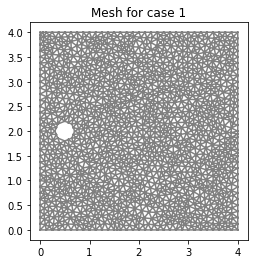

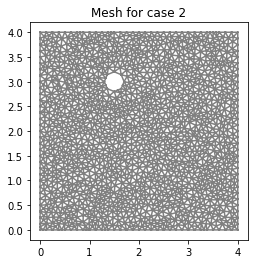

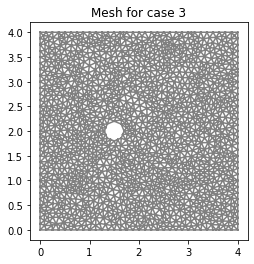

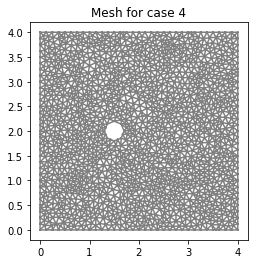

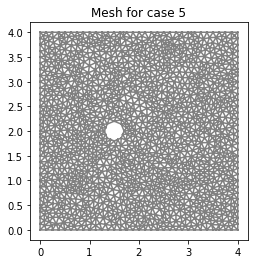

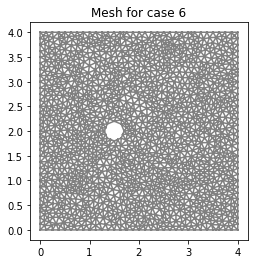

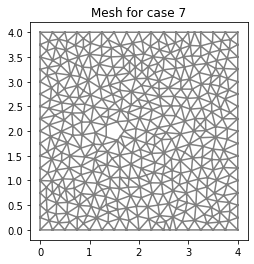

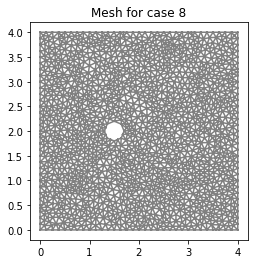

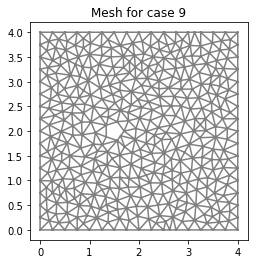

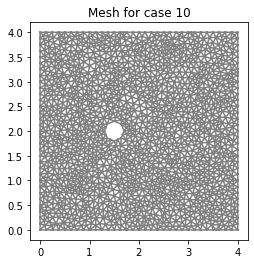

In [0]:
for index, result in enumerate(run_configurations):
  
  title_index = index + 1

  plt.figure()
  plot(result["mesh"], title=f"Mesh for case {title_index}")
  plt.show()



# **Results**

**One time mesh refinement**

For case 1-3 the adaptive mesh refinement based on the calculated error clearly follows the obstacle in the flow, but also where the combination of the obstacle and the wall have a joint impact. There is a steeper velocity gradient closer to the wall then in the midstream between the obstacle and the wall as is also shown in the mesh refinement for case 2.

Case 4 where the momentum equation is changed for the adjoint solution some aditional refinement is needed behind the cylinder. 
Case 5 where continuity no longer is 0 the combination with our outflow condition gives more "activity" at the inflow boundary.
Case 6 have the direction of the force on the circular boundary change to the $y$-direction which also requires more refinement in that direction on the wall boundaries to the right of the cylinder.

It should also be noted in case 7 and 9 that starts with coarser meshes that the shape of the object does not alter with the refinement of the mesh. Here the original low resolution renders the circle as a pentagon, and the mesh refinement gives a higher resolution around same pentagon resulting not in the solution of flow around a cylinder no matter how many times it is refined. The geometry needs to be sufficiently resolved to start with.

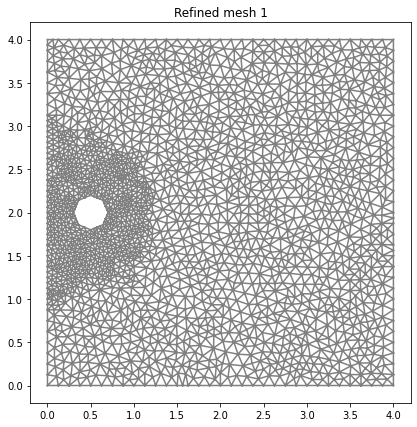

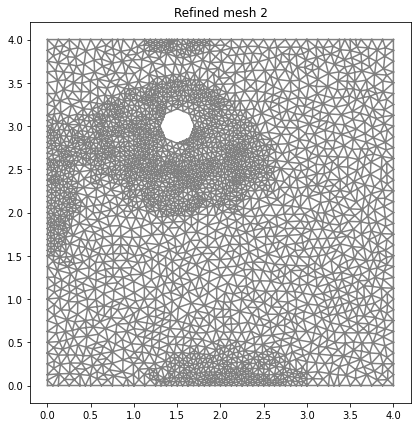

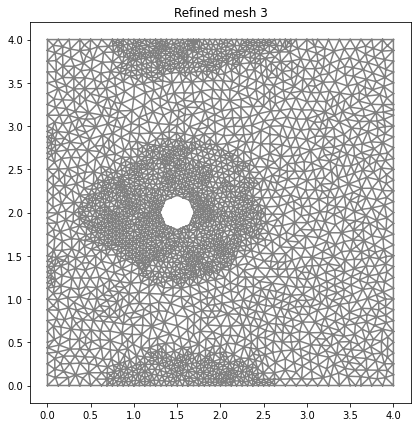

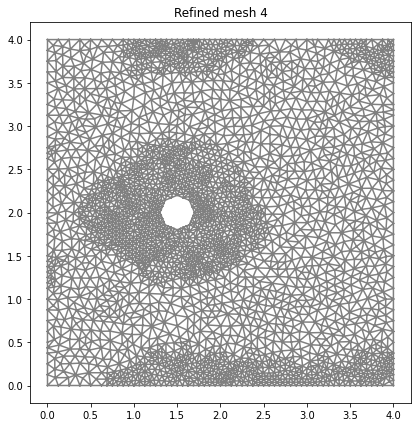

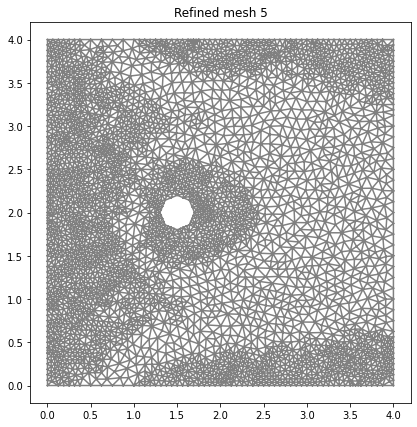

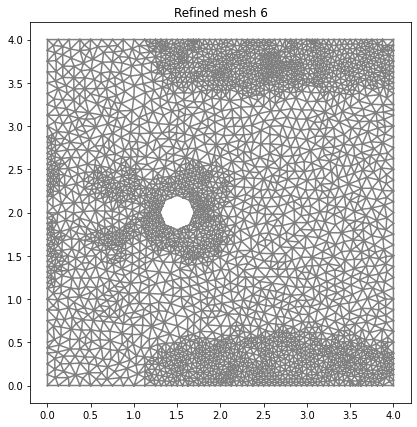

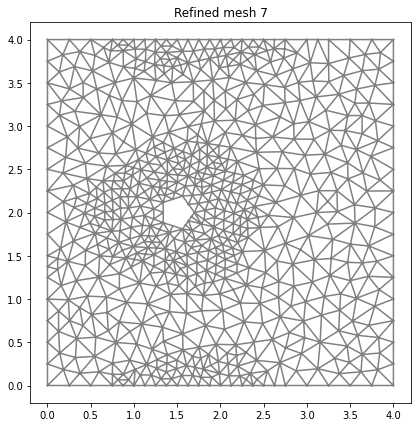

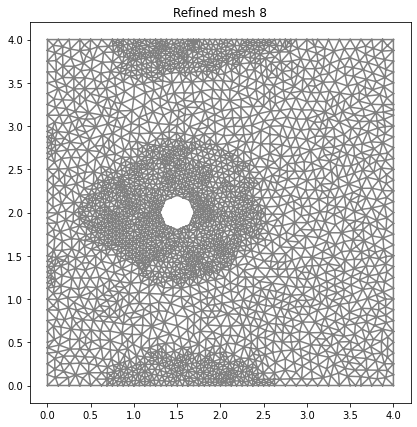

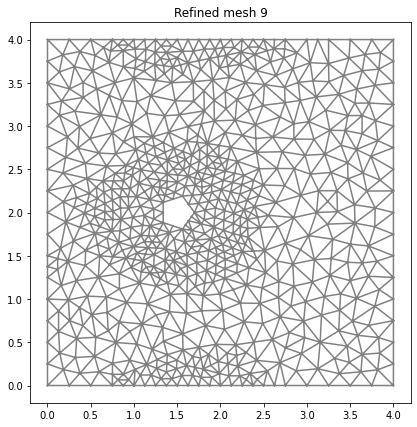

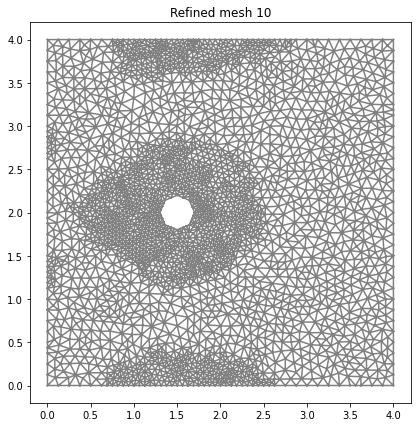

In [0]:
for index, result in enumerate(results):
  
  title_index = index + 1

  plt.figure(figsize=(10,7))
  plot(results[index]["mesh"], title=f"Refined mesh {title_index}")

  plt.show()

**Velocity and pressure for the different geometries**

The adjoint solution resembles a doublet in visualization with its highest velocity in the middle of the circle and then flowing in and out from it at opposite ends forming a vortex on each side (most clearly seen in case 3 far from the wall).

4. Changing $\psi_1$ from (0,0) to (0,1) gives an additional vortex in the adjoint solution in the $y$-direction at the outflow boundary.
5. Changing $\psi_2$ from 0 gives a case where there no longer is a "doublet" in the circle but a large influx in the $x$-direction at the outflow boarder.
6. The direction of the flow on the cylinder border is changed to $\psi_3 = (0,1)$ and in the adjoint solution the "doublet" is turned $90^{\circ}$ to have its outflow in the positive $y$-direction.


The pressure solutions follow the velocity and is close to the same for the primal and adjoint solution for case 1-3 and 7-10. When $\psi$ is changed however, the pressure solutions for the adjoint in case 4-6 no longer follows the primal solution. 


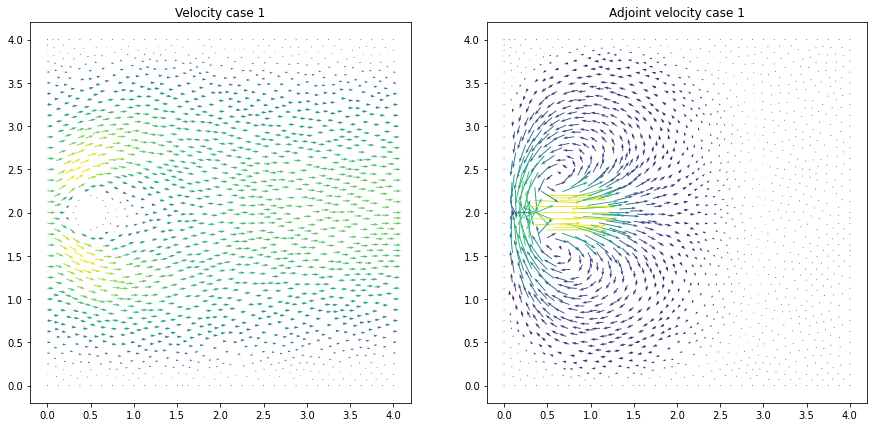

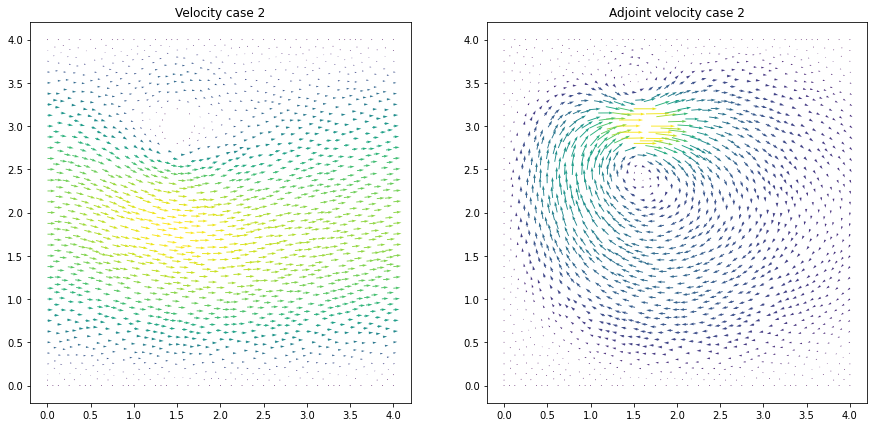

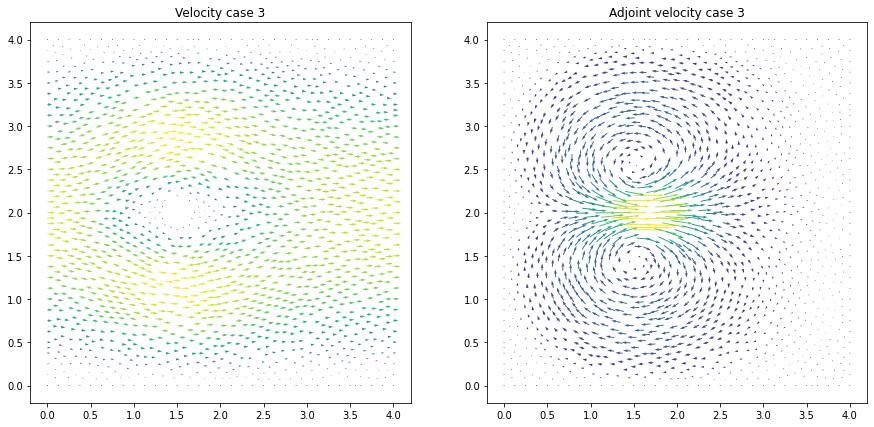

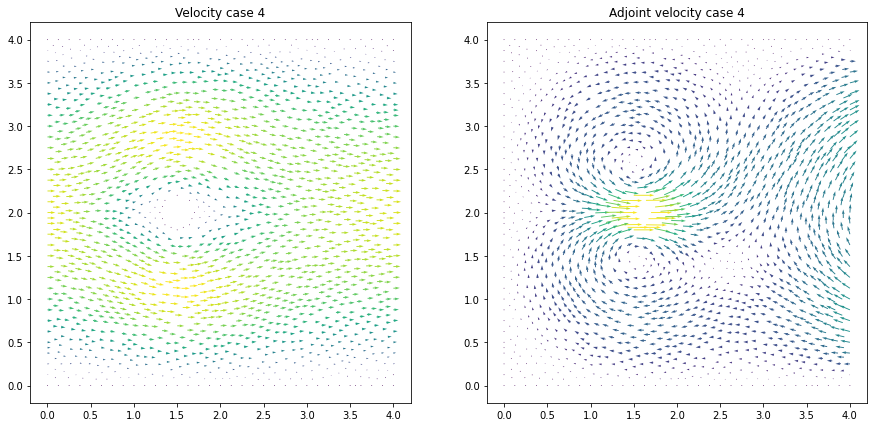

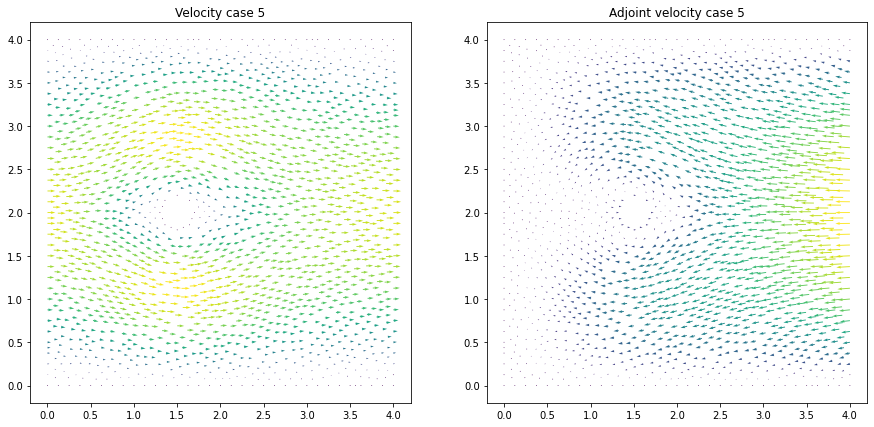

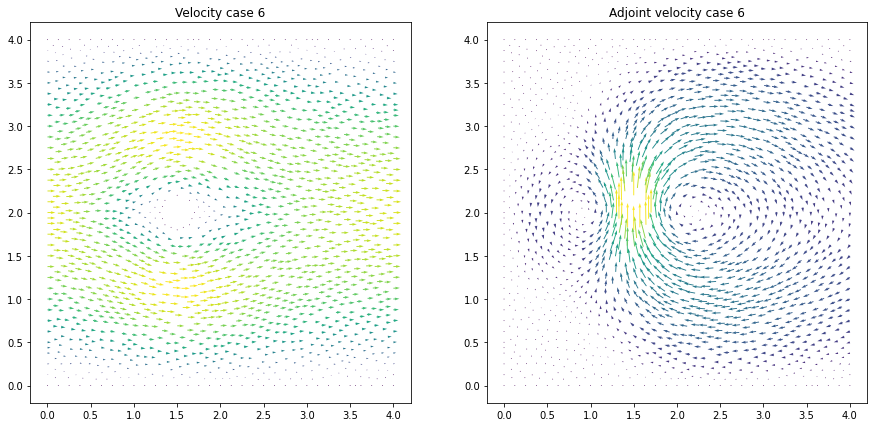

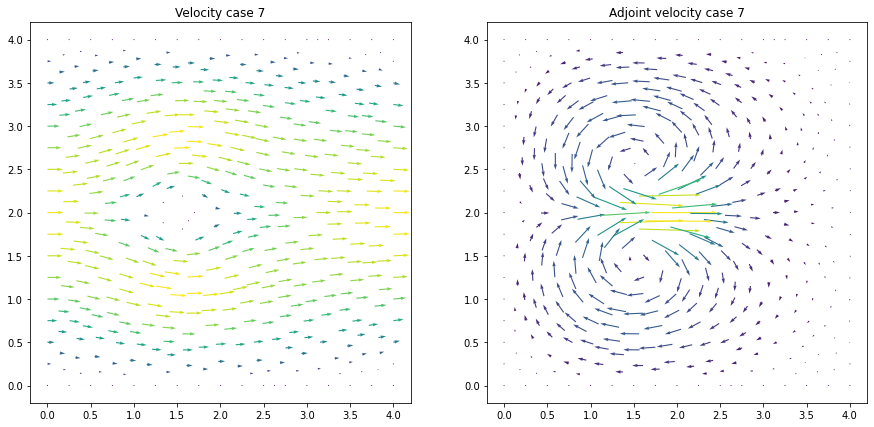

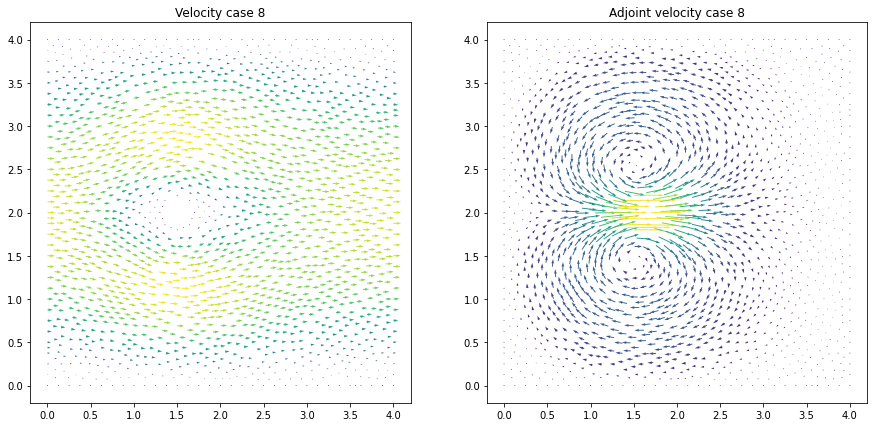

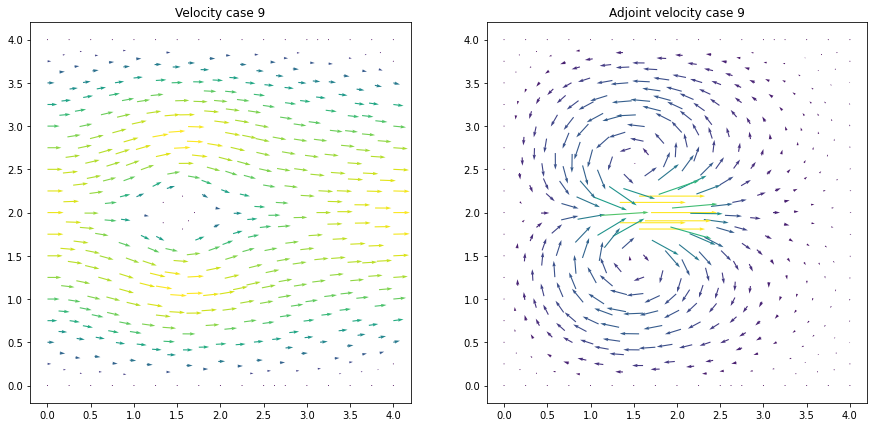

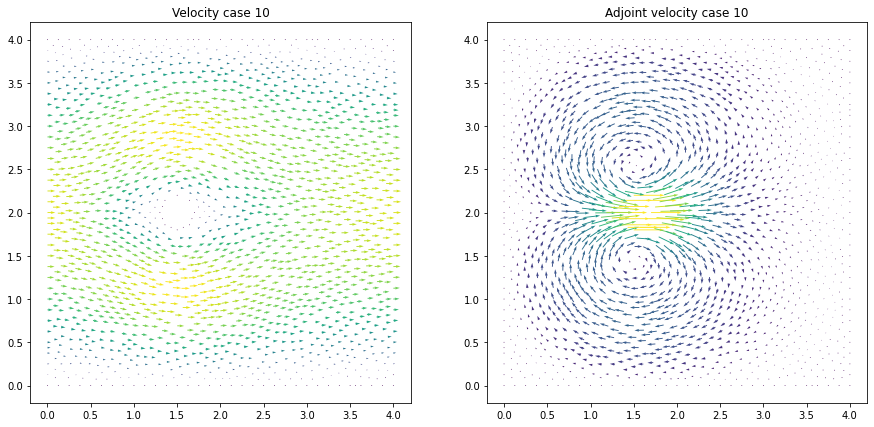

In [0]:
# Plot velocity solutions

for index, result in enumerate(results):
  
  title_index = index + 1

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plot(results[index]["u_fcn"], title=f"Velocity case {title_index}")

  plt.subplot(1,2,2)
  plot(results[index]["phi_fcn"], title=f"Adjoint velocity case {title_index}")

  plt.show()

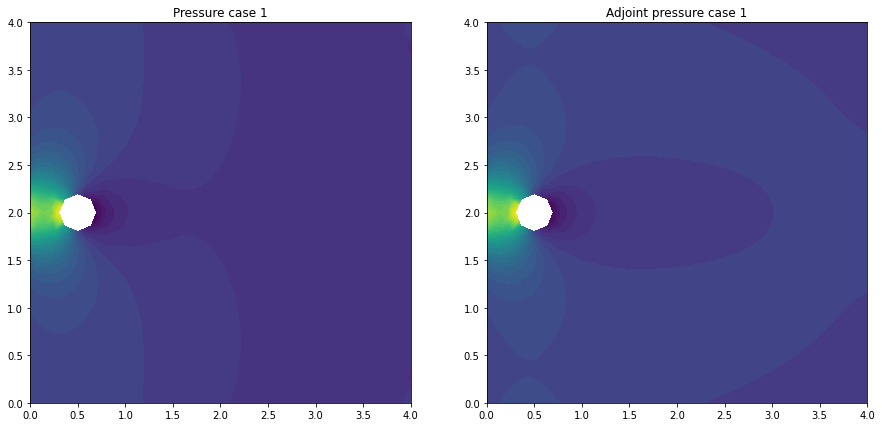

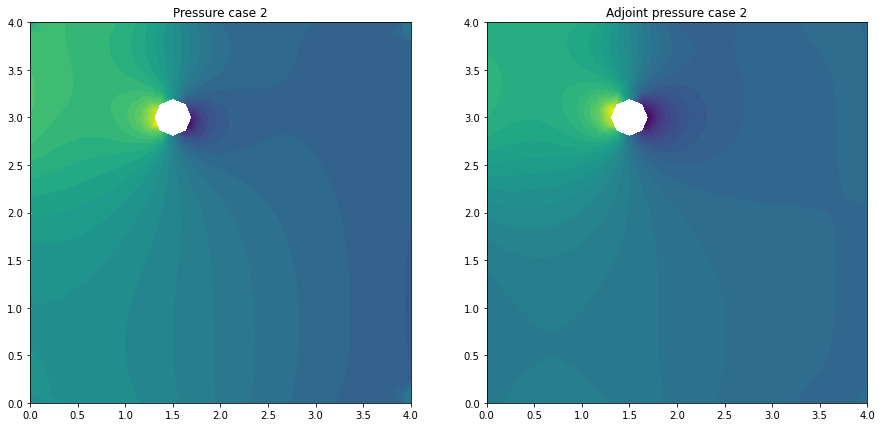

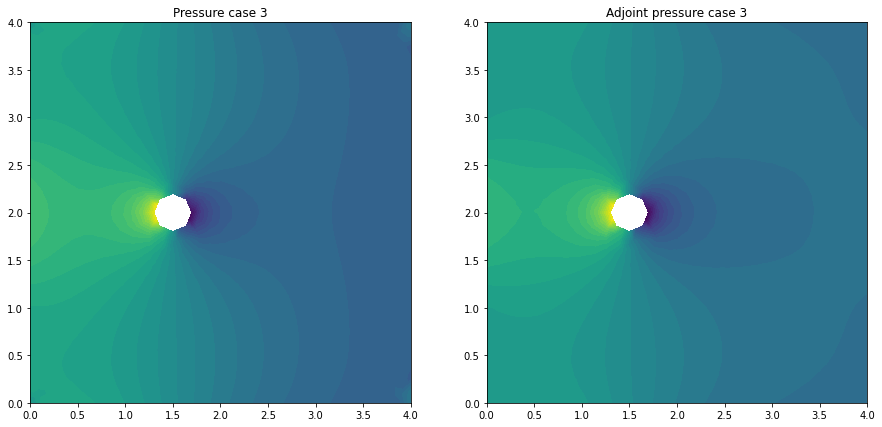

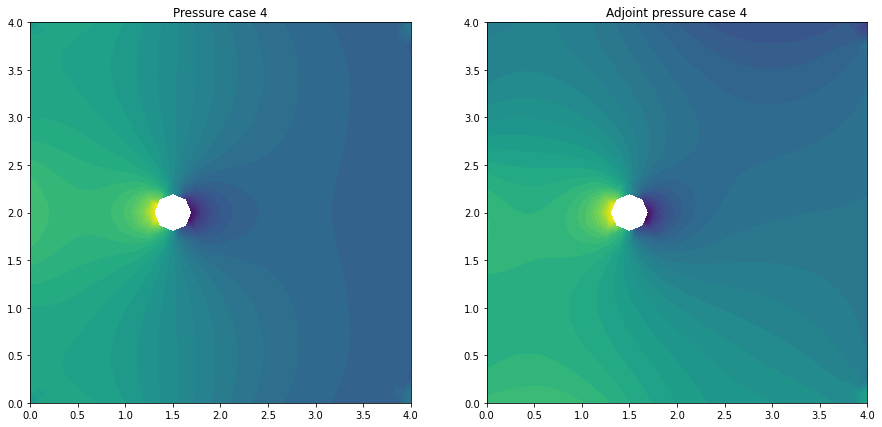

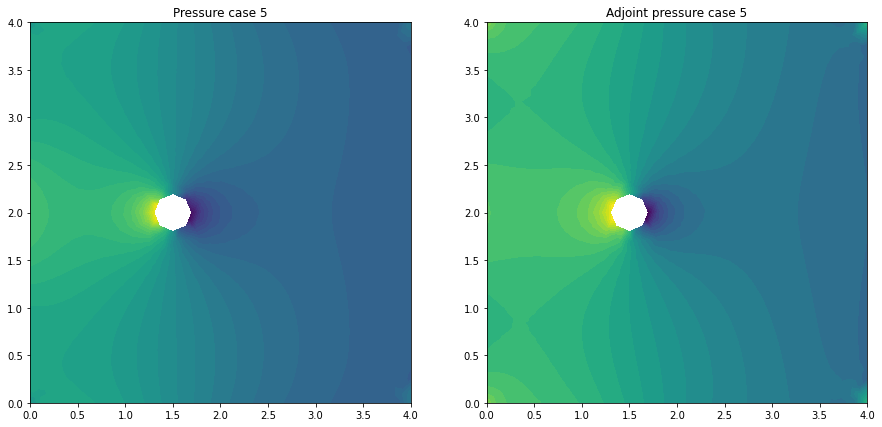

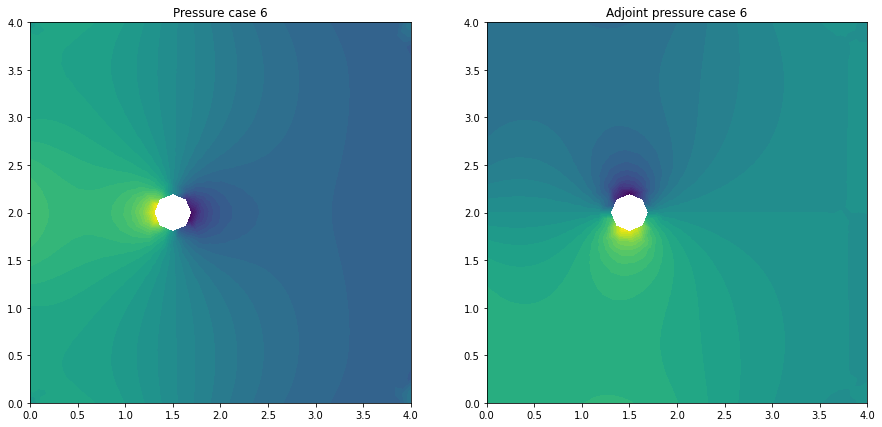

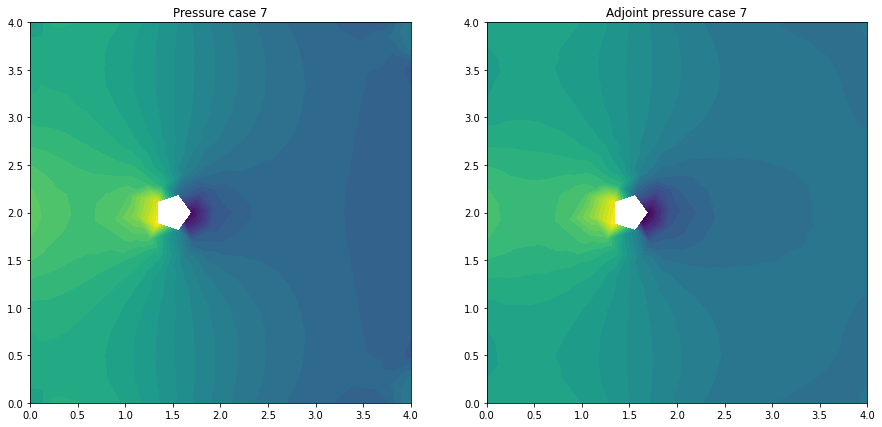

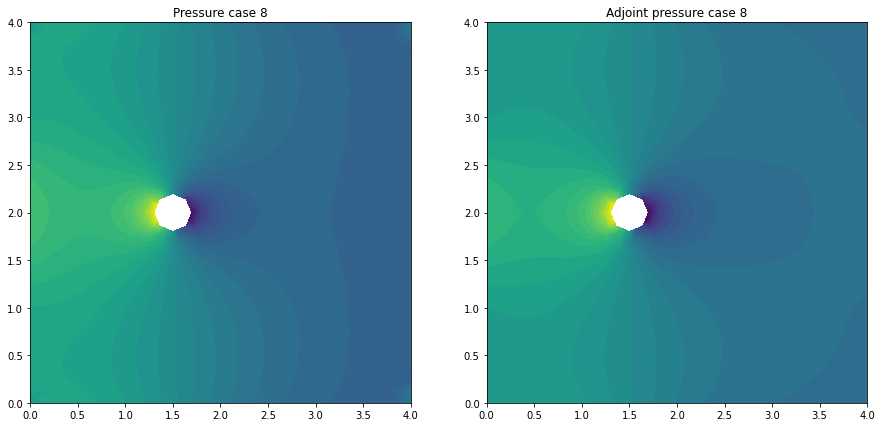

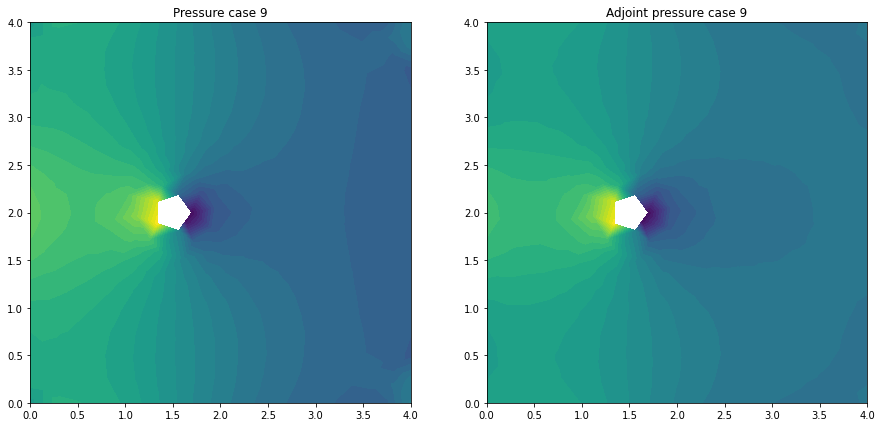

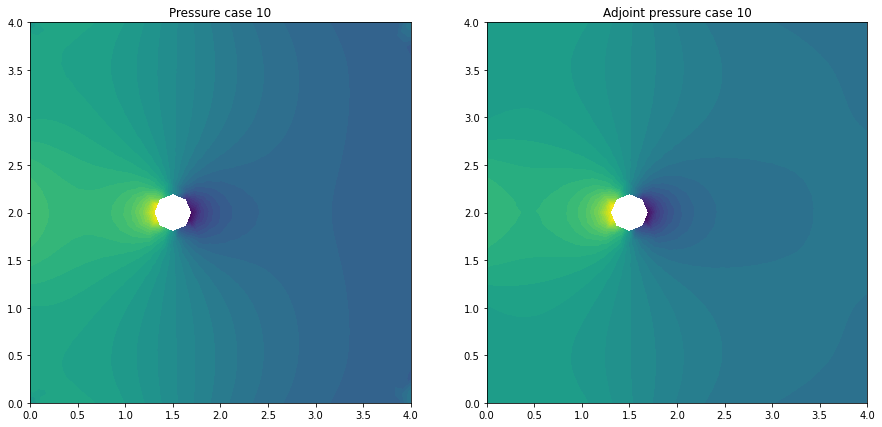

In [0]:
# Plot pressure solutions

for index, result in enumerate(results):
  
  title_index = index + 1

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plot(results[index]["p_fcn"], title=f"Pressure case {title_index}")

  plt.subplot(1,2,2)
  plot(results[index]["theta_fcn"], title=f"Adjoint pressure case {title_index}")

  plt.show()

**The total error**

With the same approximation spaces for the primal and the adjoint problem, cases 9 and 10, the total error is close to zero for both mesh resolutions. If instead case 7 and 8 are compared, where the polynomial order of the adjoint finite element spaces are higher than for the primal problem, the error decreases with increasing mesh resolution. The close to zero error in 7 and 8 is a consequence of approximating the exact adjoint solution with a finite element function in the test space of the primal problem, for which the weak form is zero, as is noted in the assignment.

In [0]:
for index, result in enumerate(results):
  
  title_index = index + 1

  s = "Total error for case " + f"{title_index}" +  " = " + repr(results[index]["tot_err"]) 
  print(s)

Total error for case 1 = 0.025461397591496307
Total error for case 2 = 0.0032593179359351908
Total error for case 3 = 0.006925055807701576
Total error for case 4 = 0.007088913784907756
Total error for case 5 = 0.004704555859361663
Total error for case 6 = 9.830852467323903e-06
Total error for case 7 = 0.03469616829987157
Total error for case 8 = 0.006925055807701576
Total error for case 9 = -4.113352928126861e-14
Total error for case 10 = -1.4011473726154358e-13


**Iterative mesh refinement**

By thresholding over a maximum value for the total error the mesh refinement is reiterated until a satisfactory total error is reached. 

Here the initial mesh has a resolution of 16, which means that the circle is not a circle. But the division of elements become more visible using this as an example.

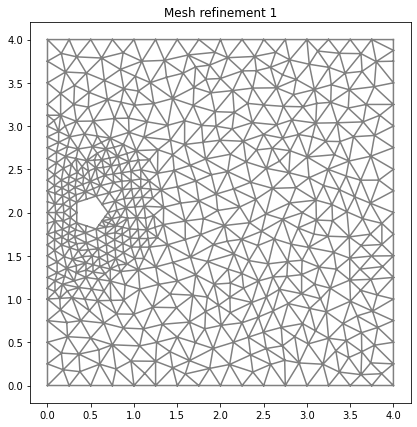

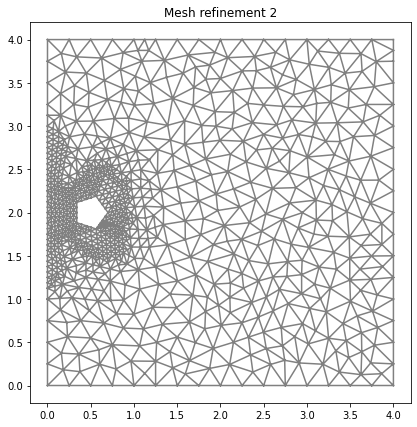

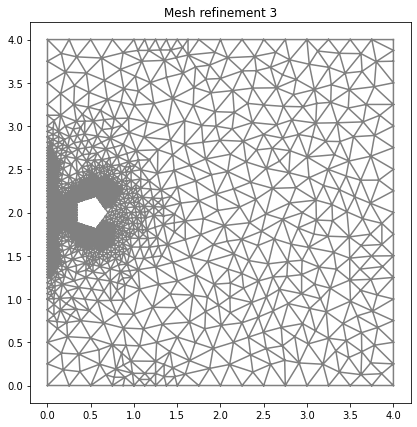

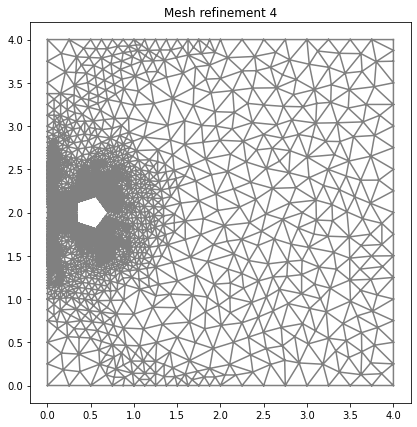

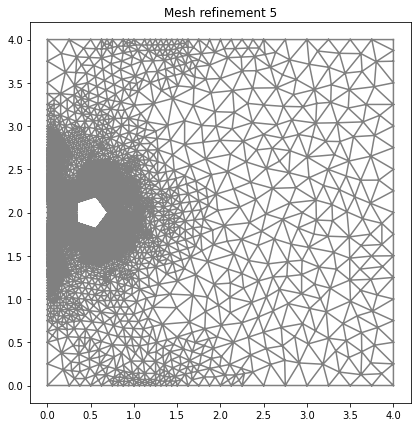

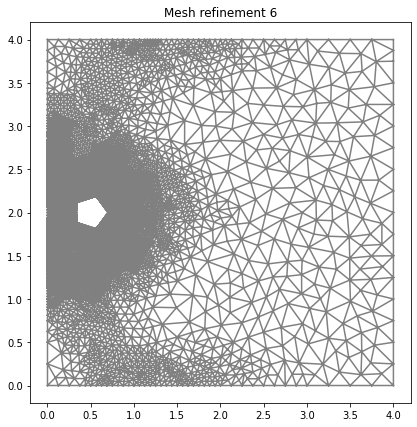

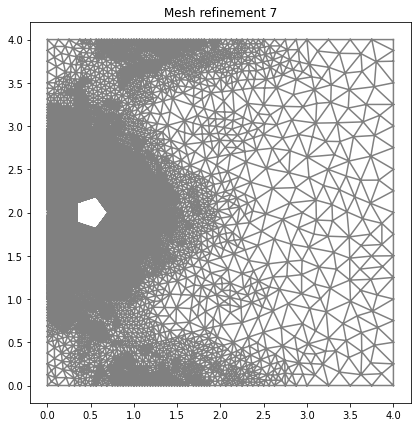

In [0]:
# Define rectangular domain 
L = 4
H = 4

# Define circle
xc = 0.5
yc = 0.5*H
rc = 0.2

# Generate meshes 
resolution = 16

mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)
results = list()

tot_err = 1
counter = 1

while tot_err > 0.005:
  
  # Generate mixed finite element spaces (for primal velocity and pressure)
  VE = VectorElement("CG", mesh.ufl_cell(), 2)
  QE = FiniteElement("CG", mesh.ufl_cell(), 1)
  WE = VE * QE

  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)

  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W) 

  # Generate mixed finite element spaces (for adjoint velocity and pressure)
  VEa = VectorElement("CG", mesh.ufl_cell(), 3)
  QEa = FiniteElement("CG", mesh.ufl_cell(), 2)
  WEa = VEa * QEa

  Wa = FunctionSpace(mesh, WEa)
  Va = FunctionSpace(mesh, VEa)
  Qa = FunctionSpace(mesh, QEa)

  # Define adjoint trial and test functions
  wa = Function(Wa)
  (phi, theta) = (as_vector((wa[0],wa[1])), wa[2])
  (va, qa) = TestFunctions(Wa)

  # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element()) 

  # Inflow boundary (ib), outflow boundary (ob), body boundary (bb) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element()) 
  wb = Expression("near(x[1],YMIN) || near(x[1],YMAX) ? 1. : 0.", YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())
  bb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN, YMAX=YMAX, element = Q.ufl_element())

  # Set boundary penalty parameter gamma 
  h = CellDiameter(mesh)
  C = 1.0e3
  gamma = C/h

  # Set force in primal problem
  f = Expression(("0.0","0.0"), element = V.ufl_element())

  # Set data that describe the functional that defines the adjoint problem
  psi1 = Expression(("0.0","0.0"), element = V.ufl_element())
  psi2 = Expression("0.0", element = Q.ufl_element())
  psi3 = Expression(("1.0","0.0"), element = V.ufl_element())

  # Define primal variational problem on residual form: r(u,p;v,q) = 0
  res = ( -p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx - inner(f, v)*dx + 
          gamma*(ib*inner(u - uin, v) + wb*inner(u, v) + bb*inner(u, v))*ds )

  # Solve primal algebraic system 
  solve(res == 0, w) 

  # Define adjoint variational problem on residual form: r(u,p;v,q) = 0
  res_a = ( -qa*div(phi)*dx + inner(grad(va), grad(phi))*dx + div(va)*theta*dx + 
            gamma*(ib*inner(phi, va) + wb*inner(phi, va) + bb*inner(phi - psi3, va))*ds 
          - inner(va, psi1)*dx - qa*psi2*dx )

  # Solve adjoint algebraic system 
  solve(res_a == 0, wa) 

  # Initiate functions to save and visualize the solutions
  u_fcn = project(u, V)
  p_fcn = project(p, Q)
  phi_fcn = project(phi, V)
  theta_fcn = project(theta, Q)


  # Define function space over the elements of the mesh
  WDG = FunctionSpace(W.mesh(), "DG", 0)
  elm = TestFunction(WDG)
  err_ind = Function(WDG)


  # Compute local error indicators over the cells of the mesh 
  local_error = ( elm*inner(f, phi)*dx + elm*p*div(phi)*dx - elm*inner(grad(u), grad(phi))*dx - elm*div(u)*theta*dx ) 
  err_ind.vector()[:] = assemble(local_error)
  err_ind_abs = np.abs(err_ind.vector())
  err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

  # Local mesh refinement (specified by a cell marker)
  no_levels = 1
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for c in cells(mesh):
      cell_marker[c] = False
      local_error_cell = err_ind_abs[c.index()] 
      if local_error_cell > err_ind_mean:
          cell_marker[c] = True
    mesh = refine(mesh, cell_marker)


  err_ind_sum = ( inner(f, phi)*dx + p*div(phi)*dx - inner(grad(u), grad(phi))*dx - div(u)*theta*dx - 
                gamma*(ib*inner(u - uin, phi) + wb*inner(u, phi) + bb*inner(u, phi))*ds )

  tot_err = assemble(err_ind_sum)

  results.append(dict(u_fcn=u_fcn,p_fcn=p_fcn,phi_fcn=phi_fcn,theta_fcn=theta_fcn,mesh=mesh,tot_err=tot_err))

  plt.figure(counter, figsize=(15,7))
  plot(results[counter-1]["mesh"], title=f"Mesh refinement {counter}")

  counter = counter + 1



# **Discussion**

A adaptive finite element method was implemented in FEniCS to solve the Stokes equations in 2D. An adjoint problem was defined with respect to a chosen linear functional, after which the residual and the solution to the adjoint was used to define an error indicator over the mesh.

When using the mesh adaption it is important to realize what part of the setup is actually resolved. Geometry errors will not be reduced, they have to be trated in the initial meshing.

